 - https://en.wikipedia.org/wiki/Observer_pattern#Python
 - https://en.wikipedia.org/wiki/Reactive_programming
 - https://stackoverflow.com/questions/6190468/how-to-trigger-function-on-value-change
 - https://www.python.org/doc/essays/graphs/ 
 - https://stackoverflow.com/questions/48336820/using-decorators-to-implement-observer-pattern-in-python3
 - https://github.com/victorcmoura/notifyr/tree/master/notifyr
 - https://codereview.stackexchange.com/questions/253675/a-python-decorator-for-an-observable-property-that-notifies-observers-when-th/253714#253714?newreg=04c9ad06b7164ef9b8fc4a7f32af2ee9


# Using numpy/broadcasting : defining a set of inputs for a model

In [1]:
from physipy import m, s, K, kg
import numpy as np

Creation of combinations is no "simple" but very doable using meshgrid : but be carefull, combinations grow **FAST** : 

In [2]:
# uniform sampling
lenghts = np.linspace(0.4, 0.8, num=3)*m
times = np.linspace(1, 10, num=3)*s
temps = np.linspace(300, 310, num=2)*K
# random sampling
mass = np.random.randn(100)*3*kg + 100*kg


LENGTHS, TIMES, TEMPS, MASS= np.meshgrid(lenghts, times, temps, mass)

lenghts = LENGTHS.flatten()
times = TIMES.flatten()
temps = TEMPS.flatten()
mass = MASS.flatten()

In [3]:
print(mass.shape)

(1800,)


Once again, thanks to numpy, we can make a computation for all possibilities at once : 

In [4]:
some_metric = lenghts*times/temps**2*np.exp(mass/(50*kg))

In [5]:
some_metric

<Quantity : [3.25430941e-05 2.97781433e-05 3.20889716e-05 ... 6.44143547e-04
 6.13318183e-04 6.17310440e-04] m*s/K**2, symbol=UndefinedSymbol*UndefinedSymbol/UndefinedSymbol**2*UndefinedSymbol>

In [6]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame(
    {
        "length":lenghts,
        "times":times,
        "temps":temps,
        "mass":mass,
        "some_metric":some_metric,
    }
)
df.head()

/Users/mocquin/MYLIB10/MODULES/physipy/physipy/quantity/quantity.py:708: UserWarning: The unit of the quantity is stripped for __array__
  warnings.warn(f"The unit of the quantity is stripped for {item}")
/Users/mocquin/MYLIB10/MODULES/physipy/physipy/quantity/quantity.py:708: UserWarning: The unit of the quantity is stripped for __array_struct__
  warnings.warn(f"The unit of the quantity is stripped for {item}")


,length,times,temps,mass,some_metric
0,0.4,1.0,300.0,99.545515,0.000033
1,0.4,1.0,300.0,95.105990,0.000030
2,0.4,1.0,300.0,98.842877,0.000032
3,0.4,1.0,300.0,97.495198,0.000031
4,0.4,1.0,300.0,94.674054,0.000030


<AxesSubplot: >

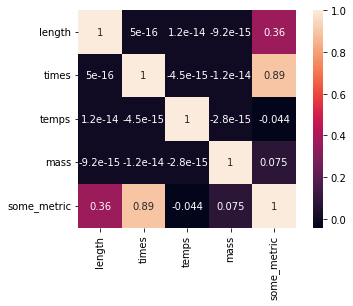

In [7]:
sns.heatmap(df.corr(), annot=True, square=True)

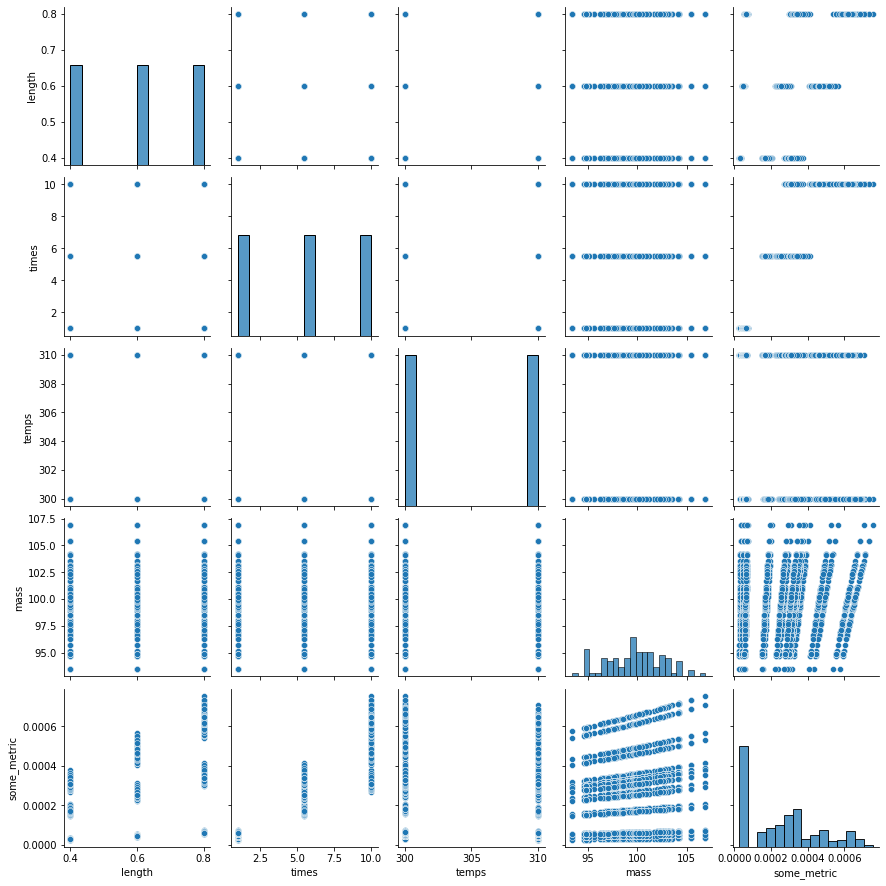

In [8]:
sns.pairplot(df)

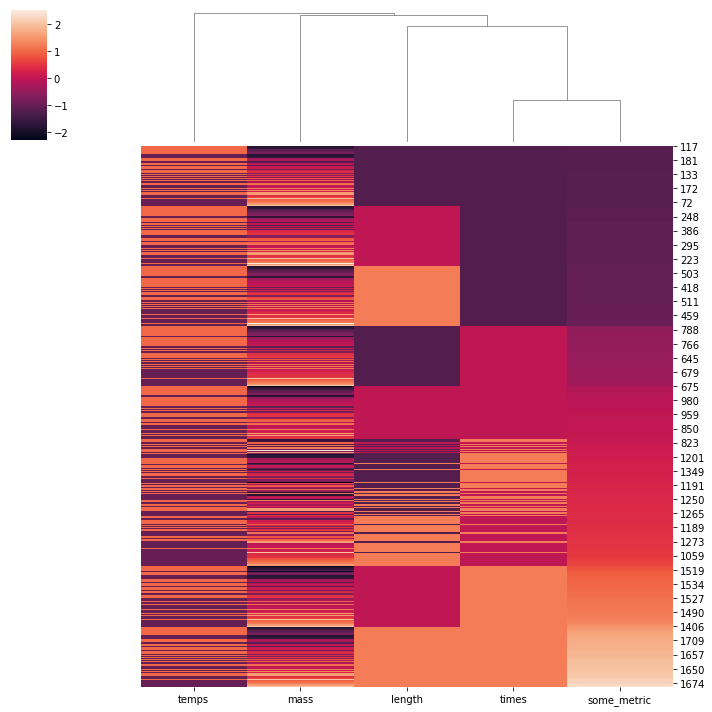

In [9]:
sns.clustermap(df.sort_values("some_metric"),z_score=1, row_cluster=False)
#sns.clustermap(df.sort_values("some_metric"),standard_scale=1, row_cluster=False)

# Cache a property with dependency

Based on https://stackoverflow.com/questions/48262273/python-bookkeeping-dependencies-in-cached-attributes-that-might-change

Let's make a simply RC model :

## Using a builtin decorator `cached_property_depends_on`

PROS : 
 - only a decorator needed
CONS : 
 - no triggering at value change or dependcy graph

In [10]:
import time
from functools import lru_cache
from operator import attrgetter

from physipy.quantity.utils import cached_property_depends_on

class BADTimeConstantRC:
    
    def __init__(self, R, C):
        self.R = R
        self.C = np.linspace(0*Farad, C)
        
    @property
    def tau(self):
        print("Slow computation...")
        time.sleep(5)
        return self.R * self.C
    
class GOODTimeConstantRC:
    
    def __init__(self, R, C):
        self.R = R
        self.C = np.linspace(0*Farad, C)
    
    @cached_property_depends_on('R', 'C')
    def tau(self):
        print("Slow computation...")
        time.sleep(5)
        return self.R * self.C
    
    
from physipy import units
ohm = units["ohm"]
Farad = units["F"]
bad = BADTimeConstantRC(ohm, Farad)
print("Bad first : ", bad.tau) # This is long the first time...
print("Bad second : ", bad.tau) # ... but also the second time !

good = GOODTimeConstantRC(ohm, Farad)
print("Good fisrt : ", good.tau) # This is long the first time...
print("Good second : ", good.tau) # ... but not the second time since neither R nor C have changed.

Slow computation...
Bad first :  [0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67346939 0.69387755 0.71428571
 0.73469388 0.75510204 0.7755102  0.79591837 0.81632653 0.83673469
 0.85714286 0.87755102 0.89795918 0.91836735 0.93877551 0.95918367
 0.97959184 1.        ] s
Slow computation...
Bad second :  [0.         0.02040816 0.04081633 0.06122449 0.08163265 0.10204082
 0.12244898 0.14285714 0.16326531 0.18367347 0.20408163 0.2244898
 0.24489796 0.26530612 0.28571429 0.30612245 0.32653061 0.34693878
 0.36734694 0.3877551  0.40816327 0.42857143 0.44897959 0.46938776
 0.48979592 0.51020408 0.53061224 0.55102041 0.57142857 0.59183673
 0.6122449  0.63265306 0.65306122 0.67

## using the acylic_model

This is another way to write a model with dependencies. Like the previous one, changing a parameter doesn't immediately triggger a computation of dependendant parameters, only at get-time.

PROS : 
 - dependency graph automatic  

CONS : 
 - definition of parameter is disinguished from computation method

In [29]:
from physipy import units, s
F = units["F"]
ohm = units["ohm"]

from physipy.quantity._acyclic_model import IndependentAttr, DeterminantAttr

class TimeConstant():
    # This class corrects the dependency problems in the DataflowFail class by using the following descriptors:
    # The following defines the directed acyclic computation graph for these attributes.
    R = IndependentAttr(ohm, 'R')
    C = IndependentAttr(F,  'C')
    tau = DeterminantAttr(['R', "C"], '_tau', 'tau')

    def _tau(self):
        print("Throu _tau")
        self.tau = self.R * self.C


tc = TimeConstant()
print(tc.R, tc.C)
print(tc.tau)
tc.R = 2*ohm
print(tc.tau)
print(tc.tau)
tc.R = 2*ohm
print(tc.tau)

1.0 kg*m**2/(A**2*s**3) 1.0 A**2*s**4/(kg*m**2)
Throu _tau
1.0 s
Throu _tau
2.0 s
2.0 s
Throu _tau
2.0 s


# Dynamic models

## Using traitlets and widgets

Lets try to make the RC model using traitlets

PROS : 
 - 
 
CONS :  
 - tau and compute_tau are separeted

In [9]:
import traitlets
import ipywidgets as ipyw
from physipy import units, s, Quantity
from physipy.qwidgets.qipywidgets import QuantityTextSlider, QuantityText, QuantitySliderDescriptor
F = units["F"]
ohm = units["ohm"]

    
class QuantityLabelDescriptor():
    
    def __init__(self, deps_names, cb_name):
        self.deps_names = deps_names
        self.cb_name = cb_name
        
    
    def __set_name__(self, owner, name):
        print("setting name for label", name)
        # self.R
        self.public_name = name
        # actually refers to self._R_w
        self.private_name_w=  name + "_w"
        # 
        self.private_name_q = name + "_q"
        
        ## if widget already exists
        #if hasattr(owner, self.private_name):
        #    # get the private widget value, and set its value to the result of compute_
        #    setattr(getattr(owner, self.private_name), "value", getattr(owner, "compute_"+self.public_name)())
        #else:
        #    print("create new widget")
        #    setattr(owner, self.private_name, ipyw.Label(self.public_name + ":" + ""))
        #    # get the widget
        #    w = getattr(owner, self.private_name)
        #    # set the widget value to
        #    setattr(w, "value", str(getattr(owner, "compute_"+self.public_name)(owner)))

            
    def _update_text(self, obj):
        setattr(obj, self.private_name_w+"value", str(getattr(obj, self.private_name_q)))
    
    
    def __get__(self, obj, objtype):
        # quantity never computed yet
        for dep in self.deps_names:
            # get the ref to the widget of the dependency
            print('setting the callbacks')
            getattr(obj, dep+"_w").observe(lambda e:self._update_text(obj), "value")
        
        if hasattr(obj, self.private_name_q):
            return getattr(obj, self.private_name_q)
        else:

            print("trying to compute")
            res = getattr(obj, "compute_"+self.public_name)()
            setattr(obj, self.private_name_q, res)
            setattr(obj, self.private_name_w, ipyw.Label(self.public_name + ":" + str(res)))
            
            return res
    #def __get__(self, obj, objtype):
    #    if hasattr(obj, self.private_name):
    #        setattr(getattr(obj, self.private_name), "value", str(getattr(obj, "compute_"+self.public_name)()))
    #    else:
    #        print("create new widget")
    #        setattr(obj, self.private_name, ipyw.Label(self.public_name + ":" + ""))
    #    for dep in self.deps_names:
    #        # get the ref to the widget of the dependency
    #        print('setting the callbacks')
    #        getattr(obj, "_"+dep+"_w").observe(self._update_text(obj), "value")
    #    if not hasattr(obj, self.private_name):
    #        res = getattr(obj, "compute_"+self.public_name)()
    #        setattr(obj, self.private_name, ipyw.Label(self.public_name + ":" + str(res)))
    #        return res
#
    #    return getattr(obj, "compute_"+self.public_name)()
    
    def __set__(self, obj, value):
        if hasattr(obj, self.private_name_w):
            # set the actual quantity value
            setattr(obj, self.private_name_q, value)
            self._update_text(obj)
        else:
            print("create new widget")
            setattr(obj, self.private_name, ipyw.Label(self.public_name + ":" + str(value)))
            


        
class TraitletsRC():
    """
    To introspect descriptors : 
        # introspect the descriptors/attributes
        print(vars(TraitletsRC(2*ohm, 2*F)))
        # introspect the slider
        print(vars(vars(TraitletsRC(2*ohm, 2*F))["_R_w"]))
    """
    
    R = QuantitySliderDescriptor()
    C = QuantitySliderDescriptor(min=0.01*F, max=200*F)
    tau = QuantityLabelDescriptor(["R", "C"], "compute_tau")

    def __init__(self, R, C):
        self.R = R
        self.C = C
        
    
    def compute_tau(self):
        return self.R * self.C
    
    def __repr__(self):
        display(self.R_w)
        display(self.C_w)
        display(self.tau_w)
        return ""
    
rc = TraitletsRC(2*ohm, 2*F)
print(vars(rc).keys())
print(rc.R, rc.C)
print(rc.tau)
#print(rc.tau)
display(rc.R)
display(rc.C)
display(rc.C_w)
rc

setting name for label tau
dict_keys(['R_w', 'C_w'])
2.0 ohm 2.0 F
setting the callbacks
setting the callbacks
trying to compute
4.0 s


<Quantity : 2.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>

<Quantity : 2.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>

QuantityTextSlider(value=<Quantity : 2.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>, children=(QuantitySli…

QuantityTextSlider(value=<Quantity : 2.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>, children=(QuantityS…

QuantityTextSlider(value=<Quantity : 2.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>, children=(QuantitySli…

Label(value='tau:4.0 s')

In [10]:
rc.R = 4*ohm

In [11]:
rc.tau

setting the callbacks
setting the callbacks


<Quantity : 4.0 s, symbol=ohm*UndefinedSymbol*F*UndefinedSymbol>

In [12]:
for i in vars(rc):
    print(i)

R_w
C_w
tau_q
tau_w
tau_wvalue


## Using acyclic_model : dependent model
Using the acyclic module

In [41]:
from physipy import units, set_favunit, s
from physipy.quantity._acyclic_model import IndependentAttr, DeterminantAttr
import numpy as np
from numpy import exp
ms = units["ms"]
V = units["V"]
F = units["F"]
ohm = units["ohm"]


class IRC2():
    R  = IndependentAttr(1*ohm, 'R')
    C  = IndependentAttr(1*F, 'C')
    Ve = IndependentAttr(1*V, 'Ve')
    u0 = IndependentAttr(0*V, 'u0')
    
    tau = DeterminantAttr(['R', 'C'], 'compute_tau', 'tau')
    u = DeterminantAttr(['R', 'C', "Ve", "u0"], 'compute_u', 'u')

    
    def compute_tau(self):
        self.tau = self.R * self.C
        
    def compute_u(self):
        self.u = (self.u0 - self.Ve)*exp(-3*s/self.tau) + self.Ve

## ObservableQuanttity class: observable pattern
 - Standalone Quantity-Like class for a quantity
 - Update a quantity's ".value" will trigger callbacks.

In [13]:
from physipy import units
from physipy import Quantity

class ObservableQuantity(Quantity):
    
    def __init__(self, *args, cb_for_init=None, **kwargs):
        self._callbacks = []
        if cb_for_init is not None:
            self._callbacks.append(cb_for_init)
        super().__init__(*args, **kwargs)
    
    def register_callback_when_value_changes(self, cb):
        """
        Register a callback that will be called on value change.
        """
        self._callbacks.append(cb)
    
    def notify_change_in_value(self, change):
        """
        Activate all callbacks that were registered.
        """
        for callback in self._callbacks:
            callback(change)
    
    @Quantity.value.setter
    def value(self, value):
        """
        Based on Quantity.value.setter
        """
        # handle the initial setting value, we can't "get" it yet
        try:
            old = self.value
        except:
            old = "NotDefinedYet"
        if isinstance(value, (list, tuple)):
            self._value = np.array(value)
        else:
            self._value = value
        change = {"old":old, "new":value}
        self.notify_change_in_value(change)    

obs_r = ObservableQuantity(2, ohm.dimension, cb_for_init=lambda _:print("value changed"))
print(obs_r)
print(obs_r*2)
print(obs_r**2 + obs_r**2)

obs_r.register_callback_when_value_changes(lambda change:print("valuechanged with change", change))
obs_r.value = 1

value changed
2 kg*m**2/(A**2*s**3)
4 kg*m**2/(A**2*s**3)
8 kg**2*m**4/(A**4*s**6)
value changed
valuechanged with change {'old': 2, 'new': 1}


In [14]:
print(obs_r)
print(obs_r*2, type(obs_r*2))
print(obs_r+obs_r, type(obs_r+obs_r))

1 kg*m**2/(A**2*s**3)
2 kg*m**2/(A**2*s**3) <class '__main__.ObservableQuantity'>
2 kg*m**2/(A**2*s**3) <class '__main__.ObservableQuantity'>


## Using a descriptor approach

 - Registering a Quantity by declaring the other quantities that should be updated.
 - Dependent tau is immediately computed and updated.
 - For class model that wraps several quantities

In [4]:
from physipy import units, s, set_favunit, setup_matplotlib
setup_matplotlib()
import numpy as np
import matplotlib.pyplot as plt
from physipy.quantity._observables_model import ObservableQuantityDescriptor

ms = units["ms"]
ohm = units["ohm"]
F = units["F"]
V = units["V"]

class RC():
    
    R = ObservableQuantityDescriptor(["tau"])
    C = ObservableQuantityDescriptor(["tau"])
    tau = ObservableQuantityDescriptor()
    
    def __init__(self, R, C):
        self.R = R
        self.C = C
    
    def compute_tau(self, change):
        print("updating tau with", change)
        self.tau = self.R * self.C
        self.tau.favunit = ms

    @property
    def _state(self):
        return self._observables_dict
        
rc = RC(1*ohm, 1*F)
print("First getting tau")
print(rc.C, rc.R, rc.tau)

print("Now changing R")
rc.R = 2*ohm
print("Second getting tau")
print(rc.C, rc.R, rc.tau)

print(rc._state)

First getting tau
updating tau with {}
1.0 A**2*s**4/(kg*m**2) 1.0 kg*m**2/(A**2*s**3) 1000.0 ms
Now changing R
updating tau with {'old': <Quantity : 1.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>, 'new': <Quantity : 2.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>}
Second getting tau
1.0 A**2*s**4/(kg*m**2) 2.0 kg*m**2/(A**2*s**3) 2000.0 ms
{'R': <Quantity : 1.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>, 'C': <Quantity : 1.0 A**2*s**4/(kg*m**2), symbol=F*UndefinedSymbol>, 'tau': <Quantity : 1.0 s, symbol=ohm*UndefinedSymbol*F*UndefinedSymbol>}


updating response_line with {}
updating tau with {}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
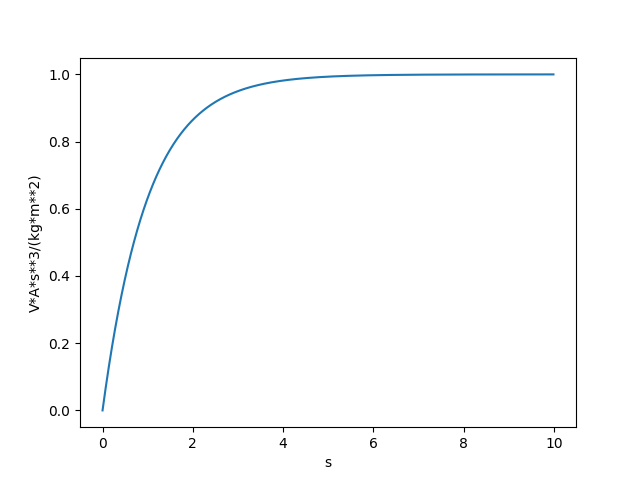

In [5]:
%matplotlib ipympl

class RC_plot():
    
    R = ObservableQuantityDescriptor(["tau"])
    C = ObservableQuantityDescriptor(["tau"])
    tau = ObservableQuantityDescriptor(["response_val"])
    response_val = ObservableQuantityDescriptor()
    
    def __init__(self, R, C, ech_t):
        self.R = R
        self.C = C
        self.ech_t = ech_t
    
    def compute_tau(self, change):
        print("updating tau with", change)
        self.tau = self.R * self.C
        self.tau.favunit = ms
        
    def compute_response_val(self, change):
        print("updating response_line with", change)
        self.response_val = self.response(self.ech_t)
        try:
            self.resp_line.set_ydata(self.response_val)
        except:
            pass
        
    @set_favunit(V)
    def response(self, t):
        return 1 - np.exp(-t/self.tau)

    def plot(self):
        fig, ax = plt.subplots()
        self.fig = fig
        self.ax = ax
        
        resp_line = self.ax.plot(self.ech_t, self.response_val)[0]
        self.resp_line = resp_line

    def get_descriptors(self):
        for k, v in vars(rc).items():
            if k.endswith("descriptor"):
                print(k, v)
        
rc = RC_plot(1*ohm, 1*F, np.arange(10, step=0.01)*s)
rc.plot()

In [6]:
rc.R

<Quantity : 1.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>

In [7]:
rc.R = rc.R /2

updating tau with {'old': <Quantity : 1.0 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol>, 'new': <Quantity : 0.5 kg*m**2/(A**2*s**3), symbol=ohm*UndefinedSymbol/UndefinedSymbol>}
updating response_line with {'old': <Quantity : 1.0 s, symbol=ohm*UndefinedSymbol*F*UndefinedSymbol>, 'new': <Quantity : 0.5 s, symbol=ohm*UndefinedSymbol/UndefinedSymbol*F*UndefinedSymbol>}


In [8]:
for k, v in rc._observables_dict.items():
    print(k, type(v))

R <class 'physipy.quantity.quantity.Quantity'>
C <class 'physipy.quantity.quantity.Quantity'>
tau <class 'physipy.quantity.quantity.Quantity'>
response_val <class 'physipy.quantity.quantity.Quantity'>


## Using autocalc

Not working out of the box for physipy, but could be done with a little work.

- https://medium.com/towards-data-science/create-a-simple-app-quickly-using-jupyter-notebook-312bdbb9d224
 - https://autocalc.readthedocs.io/en/latest/index.html
 - https://github.com/kefirbandi/autocalc


In [3]:
import ipywidgets as widgets
from autocalc.autocalc import Var
import math

a = Var('a', initial_value = 1, widget = widgets.FloatText())
b = Var('b', initial_value = -3, widget = widgets.FloatText())
c = Var('c', initial_value = 1, widget = widgets.FloatText())

display(a); display(b); display(c)


def Dfun(a, b, c):
    try:
        return math.sqrt(b*b-4*a*c)
    except ValueError:
        return math.nan

def x1fun(a,b,D):
    return (-b-D)/2/a
def x2fun(a,b,D):
    return (-b+D)/2/a


D = Var('D', fun=Dfun, inputs=[a, b, c])
x1 = Var('X1', fun=x1fun, inputs=[a, b, D], widget = widgets.FloatText(), read_only=True)
x2 = Var('X2', fun=x2fun, inputs=[a, b, D], widget = widgets.FloatText(), read_only=True)
display(x1)
display(x2)

In [5]:
a = Var('a', initial_value = 1*m, widget = QuantityText())
b = Var('b', initial_value = -3*m, widget = QuantityText())
c = Var('c', initial_value = 1*m, widget = QuantityText())

display(a); display(b); display(c)


def Dfun(a, b, c):
    try:
        res = (b*b-4*a*c)**0.5
        print(res)
        return res
    except ValueError:
        return math.nan

def x1fun(a,b,D):
    res = (-b-D)/2/a
    return res
def x2fun(a,b,D):
    return (-b+D)/2/a


D = Var('D', fun=Dfun, inputs=[a, b, c])
x1 = Var('X1', fun=x1fun, inputs=[a, b, D], widget = QuantityText(), read_only=True)
x2 = Var('X2', fun=x2fun, inputs=[a, b, D], widget = QuantityText(), read_only=True)
display(x1)
display(x2)

validating value 0.0
0.0 <class 'physipy.quantity.quantity.Quantity'>
validating value 1 m
1 m <class 'physipy.quantity.quantity.Quantity'>
validating value 0.0
0.0 <class 'physipy.quantity.quantity.Quantity'>
validating value -3 m
-3 m <class 'physipy.quantity.quantity.Quantity'>
validating value 0.0
0.0 <class 'physipy.quantity.quantity.Quantity'>
validating value 1 m
1 m <class 'physipy.quantity.quantity.Quantity'>


2.23606797749979 m**1.0
validating value 0.0
0.0 <class 'physipy.quantity.quantity.Quantity'>


TraitError: The 'value' trait of a QuantityText instance expected a Quantity, not the float 0.3819660112501051.

## pyqtgraph parameter tree

Not what I thought, basicaly just nested parameters

# Observable descriptor with dependency

In [64]:
from physipy import units

W = units["W"]


class ObservableProperty:
    
    def __set_name__(self, owner: type, name: str) -> None:
        
        # generic callback setter to instance
        def add_observer(obj, observer):
            if not hasattr(obj, self.observers_name):
                setattr(obj, self.observers_name, [])
            getattr(obj, self.observers_name).append(observer)
            
        self.private_name = f'_{name}'
        self.observers_name = f'_{name}_observers'
        
        # add the callback setter to the instance
        setattr(owner, f'add_{name}_observer', add_observer)
    
    def __get__(self, obj, objtype=None):
        if obj is None:
            return self
        return getattr(obj, self.private_name)

    def __set__(self, obj, value):
        setattr(obj, self.private_name, value)
        for observer in getattr(obj, self.observers_name, []):
            # using obj here allows to use "self.toto" in callbacks
            observer(obj, value)
         
        

class Car():
    
    wheels = ObservableProperty()
    power = ObservableProperty()
    
    def __init__(self, wheels, power):
        self.wheels = wheels
        self.power = power
        
    
    @property
    def power_per_wheel(self):
        return self.power/self.wheels

    def __repr__(self):
        return "".join(["Car with ", str(self.wheels), " wheels and ", str(self.power)])
        
        
        
car = Car(4, 10*W)
car

Car with 4 wheels and 10.0 kg*m**2/s**3

In [65]:
print(car.wheels)
car.wheels = car.wheels*2
print(car.wheels)
car.add_wheels_observer(lambda obj, new:print("new is", new))
print(car.wheels)
car.wheels = car.wheels*2
car.add_wheels_observer(lambda obj, new:print("new power per wheel", obj.power_per_wheel))
car.wheels = car.wheels*2

4
8
8
new is 16
new is 32


AttributeError: 'Car' object has no attribute '_power_per_wheel'

40

In [1]:
%matplotlib qt

In [7]:
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, 2 * np.pi, 1024)
data2d = np.sin(t)[:, np.newaxis] * np.cos(t)[np.newaxis, :]

fig, ax = plt.subplots()
im = ax.imshow(data2d)
ax.set_title('Pan on the colorbar to shift the color mapping\n'
             'Zoom on the colorbar to scale the color mapping')
cbar = fig.colorbar(im, ax=ax, label='Interactive colorbar')

def update_cmap(event):
    print(ax.get_xlim())
    print(ax.get_ylim())
    d = im.get_array()
    cbar.update_normal(d)
    #cbar.set_ set_clim(vmin=np.min(d), vmax=np.max(d))    

cid = fig.canvas.mpl_connect('button_release_event', update_cmap)

def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))

cid = fig.canvas.mpl_connect('button_press_event', onclick)


#plt.show()

single click: button=1, x=316, y=714, xdata=140.244589, ydata=180.694805
(140.24458874458855, 442.23593073593054)
(421.7337662337661, 180.69480519480499)


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/5k/bf4syt7x1zjbhc6b28srzzym0000gn/T/ipykernel_56736/896444645.py", line 17, in update_cmap
    cbar.update_normal(d)
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/colorbar.py", line 539, in update_normal
    _log.debug('colorbar update normal %r %r', mappable.norm, self.norm)
AttributeError: 'MaskedArray' object has no attribute 'norm'


single click: button=1, x=226, y=544, xdata=165.359796, ydata=275.033585
(165.3597961178604, 347.2547828515568)
(353.4234743750871, 275.0335846948749)


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/5k/bf4syt7x1zjbhc6b28srzzym0000gn/T/ipykernel_56736/896444645.py", line 17, in update_cmap
    cbar.update_normal(d)
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/colorbar.py", line 539, in update_normal
    _log.debug('colorbar update normal %r %r', mappable.norm, self.norm)
AttributeError: 'MaskedArray' object has no attribute 'norm'


single click: button=1, x=712, y=360, xdata=291.879495, ydata=340.632641
(245.58061940011058, 291.8794945515807)
(340.6326405124531, 313.58676294872305)


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/5k/bf4syt7x1zjbhc6b28srzzym0000gn/T/ipykernel_56736/896444645.py", line 17, in update_cmap
    cbar.update_normal(d)
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/colorbar.py", line 539, in update_normal
    _log.debug('colorbar update normal %r %r', mappable.norm, self.norm)
AttributeError: 'MaskedArray' object has no attribute 'norm'


single click: button=1, x=608, y=368, xdata=271.717081, ydata=333.363784
(268.9167459885532, 271.7170811791663)
(333.36378365629076, 326.946348844469)


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/5k/bf4syt7x1zjbhc6b28srzzym0000gn/T/ipykernel_56736/896444645.py", line 17, in update_cmap
    cbar.update_normal(d)
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/colorbar.py", line 539, in update_normal
    _log.debug('colorbar update normal %r %r', mappable.norm, self.norm)
AttributeError: 'MaskedArray' object has no attribute 'norm'


single click: button=1, x=636, y=758, xdata=583.534632, ydata=119.742424
(372.9718614718613, 583.5346320346318)
(363.5519480519479, 119.74242424242402)


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/5k/bf4syt7x1zjbhc6b28srzzym0000gn/T/ipykernel_56736/896444645.py", line 17, in update_cmap
    cbar.update_normal(d)
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/colorbar.py", line 539, in update_normal
    _log.debug('colorbar update normal %r %r', mappable.norm, self.norm)
AttributeError: 'MaskedArray' object has no attribute 'norm'


single click: button=1, x=480, y=638, xdata=367.430736, ydata=285.976190
(-0.5, 1023.5)
(1023.5, -0.5)


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/5k/bf4syt7x1zjbhc6b28srzzym0000gn/T/ipykernel_56736/1041871135.py", line 17, in update_cmap
    cbar.set_clim(vmin=np.min(d), vmax=np.max(d))
AttributeError: 'Colorbar' object has no attribute 'set_clim'


In [23]:
from physipy import Quantity, Dimension, quantify, DimensionError, units
ohm = units["ohm"]

class BoundedQuantity(Quantity):
    
    def __init__(self, *args, min=None, max=None, cb_for_init=None, **kwargs):

        
        self._callbacks = []
        if cb_for_init is not None:
            self._callbacks.append(cb_for_init)
        
        dim = args[1]
        
        if min is None:
            min_v = 0
            min = Quantity(min_v, dim)
        else:
            min = quantify(min)

        if max is None:
            max_v = 100
            max = Quantity(max_v, dim)
        else:
            max = quantify(max)
            
        if not min.dimension == max.dimension:
            raise DimensionError(min.dimension, max.dimension)
        
        if not dim == max.dimension:
            raise DimensionError(min.dimension, max.dimension)
            
        self.min_value = min.value
        self.max_value = max.value
        #self.value = args[0]
        super().__init__(*args, **kwargs)
        
    
    @Quantity.value.setter
    def value(self, value):
        # handle the initial setting value, we can't "get" it yet
        try:
            old = self.value
        except:
            old = "NotDefinedYet"
        if isinstance(value, (list, tuple)):
            self._value = np.array(value)
        else:
            if self.min_value < value < self.max_value:
                self._value = value
            else:
                raise ValueError("Value is not between min and max")
        change_dic = {"old":old, "new":value}
        self.notify_change_in_value(change_dic)    
        
    
    def register_callback_when_value_changes(self, cb):
        """
        Register a callback that will be called on value change.
        """
        self._callbacks.append(cb)
    
    
    def notify_change_in_value(self, change_dic):
        """
        Activate all callbacks that were registered.
        """
        for callback in self._callbacks:
            callback(change_dic)
            
    def as_ipyw(self):
        """
        As slider
        """
        from physipy.qwidgets.qipywidgets import QuantityTextSlider
        s = QuantityTextSlider(self, min=self.min, max=self.max, favunit=self.favunit)
        return s            
                
def bounded_quantity(init, min, max, favunit=None):
    if favunit is None:
        favunit = init.favunit
    return BoundedQuantity(init.value, init.dimension, min=min, max=max, favunit=favunit)
                
R = bounded_quantity((2*ohm).set_favunit(ohm), 0*ohm, 3*ohm)#, favunit=ohm)
print(R)
R.value = 0.2
print(R)
R.register_callback_when_value_changes(lambda _: print("value changed"))
R.value = 0.5

2.0 ohm
0.2 ohm
value changed


In [38]:
from physipy.qwidgets.qipywidgets import QuantityTextSlider
from physipy import set_favunit, units
from physipy.quantity.utils import cached_property_depends_on
V = units["V"]
Farad = units["F"]

In [55]:
class Model():
    deps = {}
    
    def __repr__(self):
        return "Model with "+"".join([k+":"+str(v) for k, v in self.pdict.items()])
    
    @classmethod
    def register_dep(cls, base, high):
        cls.deps[high] = [b for b in base]
        
class BestRC(Model):

    def __init__(self, R, C):
        super().__init__()
        self.R = R
        self.C = C
        
    BestRC.register_dep(["R", "C"], "tau")    
    @property
    def tau(self):
        return self.R * self.C

        
    #@depends_on("tau")
    @set_favunit(V)
    def response(self, t):
        return 1 - np.exp(-t/self.tau)
        
       
    @cached_property_depends_on('R', 'C')
    def slow_tau(self):
        time.sleep(5)
        return self.tau**2

        
rc = BestRC(2*ohm, 3*Farad)
rc = BestRC(R={"init":2*ohm, "min":3*ohm},
        C=3*Farad)

print(BestRC.deps)

{'tau': ['R', 'C']}


# List of wanted features

- Handle min/max/step/initial value like a slider `
- Handle favunit
- Possibility to add callbacks after init
- Cachable on param state
- Get state of all params as a dict
- Customize __repr__ with all parameters
- Get a Model state that can be saved, with dependency
- Access a slider using _`w` on parameter value


```python
# model inerhit for repr
class BestRC(Model):

    def __init__(self, R, C):
        self.R = 
        self.C = 
    
    #@depends_on("R", "C")
    @property
    def tau(self):
        return self.R * self.C
    register_dep('R', 'C')("tau")
        
    @depends_on("tau")
    @set_favunit(V)
    def response(self, t):
        return 1 - np.exp(-t/self.tau)
        
       
    @cached_property_depends_on('R', 'C')
    def slow_tau(self):
        time.sleep(5)
        return self.tau**2

        
rc = RC(2*ohm, 3*Farad)
rc = RC(C={init=2*ohm, min=3*ohm},
        F=3*Farad)


```

In [ ]:
def decorator_creator(*param_args):
    
    # define decorator
    def decorator(func):
        def _wrapped_method(self, *method_args, **method_kwargs):
            
            return 
        return _wrapped_method
    return decorator